In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

## Load Data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print ("Data is loaded!")

Data is loaded!


C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [4]:
y = train['SalePrice'].reset_index(drop=True)

train.drop(['SalePrice'], axis=1, inplace=True)
train.drop(['Id'], axis=1, inplace=True) #inplace：不创建新的frame
test.drop(['Id'], axis=1, inplace=True)

In [5]:
features = pd.concat([train, test]).reset_index(drop=True)
print("Shape of all features : ",features.shape)

Shape of all features :  (2919, 79)


In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Data Cleaning

### Outlier

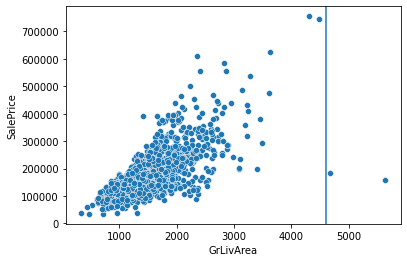

In [6]:
# GrLivArea: a quantitative feature
sns.scatterplot(data=train, x=train['GrLivArea'], y=y)
plt.axvline(4600, 0)

In [7]:
idx = train[train['GrLivArea'] > 4600].index
features = features.drop(features.index[idx]).reset_index(drop=True)
y = y.drop(y.index[idx]).reset_index(drop=True)

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
features.shape, y.shape #train.shape

((2917, 79), (1458,))

## Data Transform

### 数据类型

In [9]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [10]:
quantitative = [i for i in features.columns if features.dtypes[i] != 'object']
qualitative = [i for i in features.columns if features.dtypes[i] == 'object']

print(type(quantitative))
print("length of quantitative features : ",len(quantitative))
print("length of qualitative features : ",len(qualitative))

<class 'list'>
length of quantitative features :  33
length of qualitative features :  46



### 缺失值

Missing features who's important: Index(['Alley', 'PoolQC', 'MiscFeature'], dtype='object') 
The length of important missing features:  3
The length of all missing features:  34


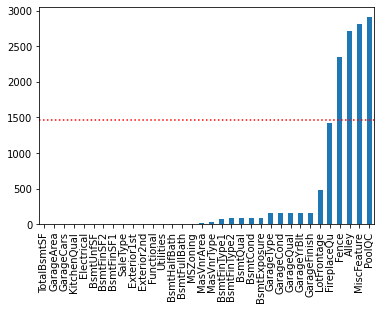

In [11]:
missing = features.isnull().sum() #NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike 
#Returns bool or array-like of bool
# Series: One-dimensional ndarray with axis labels (index).

#print(missing[:7],"\nType of missing var: ",type(missing),"; \ntype of train: ",type(train))

missing_all = missing[missing > 0]
missing_important = missing[ missing >= (0.9 * features.shape[0])]
print("Missing features who's important:",missing_important.index, "\nThe length of important missing features: ", len(missing_important))
print("The length of all missing features: ", len(missing_all))
missing_all.sort_values(inplace=True)
missing_all.plot.bar()
plt.axhline(y= (len(features)/2), color='r', linestyle=':')

In [12]:
print(train[train['PoolQC'].notnull()]["PoolQC"].unique()) #train['PoolQC'].isnull()
print(train[train['MiscFeature'].notnull()]["MiscFeature"].unique())
print(train[train['Alley'].notnull()]["Alley"].unique())

['Ex' 'Fa' 'Gd']
['Shed' 'Gar2' 'Othr' 'TenC']
['Grvl' 'Pave']


In [13]:
####用0替换掉缺失值。 
#GarageYrBlt, GarageArea and GarageCars: NA代表没有车库，用0替换掉缺失值。 
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):    
    features[col] = features[col].fillna(0)   
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: 都是地下室特征，缺失值代表没有地下室，可以用0代替缺失值。 
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):     
    features[col] = features[col].fillna(0) 
#MasVnrArea and MasVnrType: NA 意味着这些房子都没有表层砌体。我们可以面积填0，类型填None。 
features['MasVnrType'] = features['MasVnrType'].fillna('None') 
features['MasVnrArea'] = features['MasVnrArea'].fillna(0) 

#### 用None替代缺失值
#PoolQC : NA意味着没有泳池。
features['PoolQC'] = features['PoolQC'].fillna('None') 
#MiscFeature: NA 意味着没有未包含在其他类别里的混杂特征。 
features['MiscFeature'] = features['MiscFeature'].fillna('None') 
#Alley: NA 意味着没有小巷。
features['Alley'] = features['Alley'].fillna('None') 
#Fence: NA 意味着没有栅栏。
features['Fence'] = features['Fence'].fillna('None') 
#FireplaceQu: NA 意味着没有壁炉。
features['FireplaceQu'] =features['FireplaceQu'].fillna('None') 
#GarageType, GarageFinish, GarageQual and GarageCond: 用None代替缺失值。 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'): 
    features[col] = features[col].fillna('None') 
#BsmtQual, HasBsmt,BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2: 这些都是地窖特征，NaN 意味着这里没有地窖。 
for col in ('BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):     
    features[col] = features[col].fillna('None') 
                   
#MSSubClass:  NA很可能意味着没有建筑等级。
features['MSSubClass'] = features['MSSubClass'].fillna('None')      

####用常见值替代缺失值
#MSZoning : 出售中的区域类型。用常见的RL填充缺失值NA。 
features['MSZoning'] = features['MSZoning'].fillna(train['MSZoning'].mode()[0])
#Functional:家庭功能评级。用常见的Typ填补缺失值NA。
features['Functional'] =features['Functional'].fillna('Typ') 
#Electrical: 电力系统。用主要的SBrkr填补缺失值NA。 
features['Electrical'] = features['Electrical'].fillna(train['Electrical'].mode()[0])
#KitchenQual:厨房质量。用常见的TA填补缺失值NA。 
features['KitchenQual'] = features['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
#Exterior1st and Exterior2nd:房屋外部遮盖物。 1和2都只有一个缺失的值。替换成最常见的字符串VinylSd。 
features['Exterior1st'] = features['Exterior1st'].fillna(train['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
#SaleType: 售卖类型。填入最常见的"WD"  。
features['SaleType'] = features['SaleType'].fillna('WD' )

# LotFrontage这个特征与LotFrontage和Neighborhood有比较大的关系，所以这里用这两个特征分组后的中位数进行插补。
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#Utilities: 只有训练集中有一个“NoSewa”，所以这个特性对预测建模没有帮助。
features.drop(['Utilities'], axis=1, inplace=True)

In [14]:
train['Utilities'].unique(), test['Utilities'].unique()

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array(['AllPub', 'NoSeWa'], dtype=object),
 array(['AllPub', nan], dtype=object))

In [15]:
missing_now = features.isnull().sum()
print("The length of all missing features now: ", len(missing_now[missing_now > 0]))

The length of all missing features now:  0


### 正态分布

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

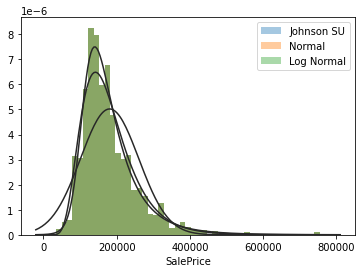

In [16]:
sns.distplot(y, kde=False, fit=stats.johnsonsu, label ='Johnson SU')
sns.distplot(y, kde=False, fit=stats.norm , label= 'Normal')
sns.distplot(y, kde=False, fit=stats.lognorm, label = 'Log Normal')
plt.legend()

In [17]:
print('Skewness: %f' % y.skew())
print('Kurtosis: %f' % y.kurt())

Skewness: 1.881296
Kurtosis: 6.523067


C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Normal'}, xlabel='SalePrice'>

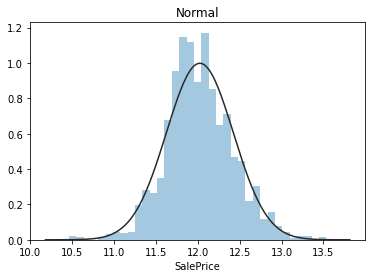

In [18]:
y = np.log(1+y)
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


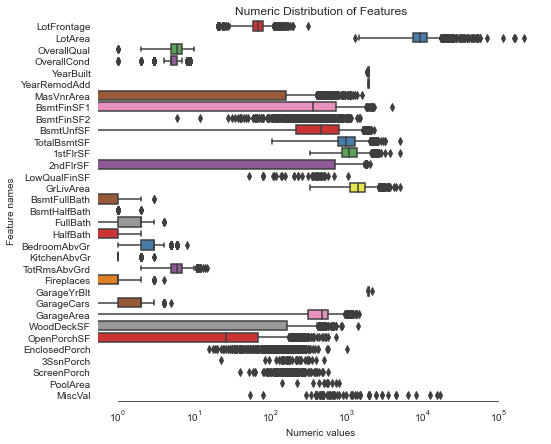

In [19]:
sns.set_style('white')
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data=features[quantitative] , orient='h', palette='Set1')
ax.xaxis.grid(False)
ax.set(ylabel='Feature names')
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features')
sns.despine(trim=True, left=True)

In [20]:
skew_features = features[quantitative].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print('There are {} quantitative features with Skew > 0.5 :'.format(high_skew.shape[0]))
#skewness = pd.DataFrame({'Skew' :high_skew})

There are 25 quantitative features with Skew > 0.5 :


C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
for i in quantitative: #skew_index: #quantitative
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\scipy\stats\stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


 ### 编码分类特征

In [22]:
features = features.replace({'Street': {'Pave': 1, 'Grvl': 0 },
                             'FireplaceQu': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0
                                            },
                             'Fence': {'GdPrv': 2,
                                       'GdWo': 2,
                                       'MnPrv': 1,
                                       'MnWw': 1,
                                       'NoFence': 0},
                             'ExterQual': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'ExterCond': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'BsmtQual': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3,
                                            'Av': 2,
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'GarageQual': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'KitchenQual': {'Ex': 5,
                                            'Gd': 4,
                                            'TA': 3,
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6}
                            })
'''
features = features.replace({'CentralAir': {'Y': 1,
                                            'N': 0}})
features = features.replace({'PavedDrive': {'Y': 1,
                                            'P': 0,
                                            'N': 0}})
'''

"\nfeatures = features.replace({'CentralAir': {'Y': 1,\n                                            'N': 0}})\nfeatures = features.replace({'PavedDrive': {'Y': 1,\n                                            'P': 0,\n                                            'N': 0}})\n"

### 组合新特征

In [23]:
#通过加总的特征
#地下室面积总面积
features['TotalBSF'] = (features['TotalBsmtSF'] + features['1stFlrSF'] +features['2ndFlrSF']
+features['BsmtUnfSF'])
#全屋浴室加总
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
#地面地下房间包括浴室加总
features['Total_Rooms'] = features['Total_Bathrooms']+  features['BedroomAbvGr'] +features['TotRmsAbvGrd']
#门廊加总
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +features['EnclosedPorch'] + features['ScreenPorch'] +features['WoodDeckSF'])
#车库面积加总
features['Total_Garage'] = features['GarageArea']+  features['GarageCars'] 
#外部有关面积数据加总
features['Outside_Area'] = features['Total_porch_sf']  + features['PoolArea']
#屋内全部楼层加地下室面积加总
features['Total_sqr'] = (features['TotalBSF'] + features['LowQualFinSF'] + features['1stFlrSF'] + features['2ndFlrSF'])

#减法
#建造，售卖时间间隔
features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearBuilt'].astype(int)
#改建，售卖时间间隔
features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)   

In [24]:
features.shape

(2917, 86)

### 重复值过多的 constant列

In [25]:
overfit = []
for i in features.columns:
    counts = features[i].value_counts() #降序Series containing counts个数 of unique values.
    zeros = counts.iloc[0]
    if zeros / len(features) * 100 > 99.94: #几乎这一列都是一个数，则认为overfit无效feature
        overfit.append(i)

overfit = list(overfit)
overfit

[]

### 字符型特征的独热编码

In [26]:
#features.info()

In [27]:
features = pd.get_dummies(features).reset_index(drop=True)
print("Length of qualitative features: ",len([i for i in features.columns if features.dtypes[i] == 'object']))

Length of qualitative features:  0


In [28]:
features.shape

(2917, 318)

# Model Fitting

In [29]:
x_train = features.iloc[:len(y), :]
x_test = features.iloc[len(y):, :]
x_train.shape, x_test.shape, y.shape #Train Set去除两个GrLivArea Outliers

((1458, 318), (1459, 318), (1458,))

### 归一化

In [30]:
scaler = RobustScaler()  #减去Median -> 对outlier不敏感
x_train = scaler.fit(x_train).transform(x_train)  #训练样本特征归一化 
x_test = scaler.transform(x_test)               #测试集样本特征归一化  

### PCA去相关

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


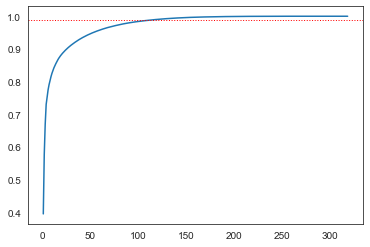

In [31]:
pca = PCA()
pca.fit(x_train)
plt.figure()
plt.plot(range(1, x_train.shape[1]+1), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.99,linewidth=1, color='r',linestyle = ':')
plt.show()

In [32]:
'''pca_model = PCA(n_components=200)
x_train = pca_model.fit_transform(x_train)
x_test = pca_model.transform(x_test)'''

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'pca_model = PCA(n_components=200)\nx_train = pca_model.fit_transform(x_train)\nx_test = pca_model.transform(x_test)'

### K - fold

In [33]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred)) #RMSE

def cv_rmse(model, X= x_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

## Models

In [34]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [35]:
#pipeline允许你封装所有的预处理步骤，特性选择，扩展，特性编码，最重要的是它帮助我们防止数据泄漏
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), 
                      LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), 
                    SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [36]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, loss='huber', 
                                max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                random_state =42)                             

In [37]:
xgboost = XGBRegressor(n_estimators=3460,learning_rate=0.01, objective='reg:linear', nthread=-1,
                        max_depth=3, min_child_weight=0, gamma=0,
                        subsample=0.7, colsample_bytree=0.7, reg_alpha=0.00006,
                        scale_pos_weight=1, seed=27 )

In [38]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [39]:
score = cv_rmse(ridge)
print("RIDGE: {:.4f} ({:.4f})".format(score.mean(), score.std()) )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})".format(score.mean(), score.std()) )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()) )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()) )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()) )

RIDGE: 0.1087 (0.0152)
LASSO: 0.1064 (0.0150)
elastic net: 0.1065 (0.0150)
SVR: 0.1081 (0.0159)
gbr: 0.1143 (0.0142)
[19:47:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror

In [40]:
print('===START Fit===========')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(x_train), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(x_train, y)

print('Lasso')
lasso_model_full_data = lasso.fit(x_train, y)

print('Ridge')
ridge_model_full_data = ridge.fit(x_train, y)

print('Svr')
svr_model_full_data = svr.fit(x_train, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(x_train, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(x_train, y)

===START Fit===========
stack_gen


C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[19:49:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

# Blending Models

In [41]:
def blend_models_predict(x_train):
    return ((0.1 * elastic_model_full_data.predict(x_train)) + \
            (0.05 * lasso_model_full_data.predict(x_train)) + \
            (0.1 * ridge_model_full_data.predict(x_train)) + \
            (0.15 * svr_model_full_data.predict(x_train)) + \
            (0.15 * gbr_model_full_data.predict(x_train)) + \
            (0.2 * xgb_model_full_data.predict(x_train)) + \
            (0.25 * stack_gen_model.predict(np.array(x_train))))

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(x_train)))

RMSLE score on train data:
0.059961183691736315


# Submission

In [43]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(x_test)))

q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

# 极大极小值 预测效果过于保守 -> 特殊处理
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("submission_version.csv", index=False)

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
submission.head()

C:\Users\ooo\AppData\Local\R-MINI~1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,SalePrice
0,1461,121603.0
1,1462,162741.0
2,1463,185423.0
3,1464,201638.0
4,1465,183879.0



### 步骤 0： 销售的log对数转换。
因变量的对数变换。预测销售对数而不是销售额有两个原因：
- 首先，评估指标取决于销售对数，
- 其次，许多货币实体的分布接近对数正态，即重尾分布。
通常最好预测不是重尾的 smt（老实说，我试图预测销售本身，结果更糟）。

### 第 1 步： 重新编码预测变量/缺失值/异常值。
一些有序的预测变量（即它们的值具有自然顺序）最初存储为因子。我以一种明智的方式对它们重新编码（有许多很棒的内核详细描述了如何做到这一点；此类预测器的示例是 ExterQual 和 BsmtCond）。

显然我必须填写缺失值 - 数值预测变量中的缺失值我在有意义时用零填充（例如，如果地下室没有浴缸，BsmtFullBath 应该等于零），分类预测变量中的缺失我用模式填充或其他典型值。

最后，许多用户建议在预测变量 OverallQual 和 GrLivArea 中删除带有异常值的观察值——这是值得做的。

### 第 2 步：非线性。
由于我计划使用线性方法（套索、岭、svm），我用它们的**对数替换了所有重尾预测变量**，并为一些预测变量**添加了它们的平方**（即我们有预测变量 X，我们添加了预测变量 X^2）。

用对数替换重尾预测变量的动机是 :
- a) 线性方法可能适合具有非常小的权重的此类预测变量，并且值中包含的大部分信息可能会丢失 
- b) 当此类预测变量取非常高的值时的预测可能是也非常高或具有误导性。

添加平方的动机是:
- 散点图中的非线性“predictor vs. log of sales” - 我们假设当我们将预测变量添加到多维模型时，类似的非线性也将成立）。例如，检查 BsmtQual 与log_sales的散点图.


### 第 3 步：新的predictor。 
对于某些预测变量，如果相应的预测变量取特定值，则有助于添加等于 1 的指标变量。 

我选择了基于散点图的预测变量和它们的值——如果在散点图上“预测变量与销售对数”对于预测变量的某个值，对数销售或非线性的值出现峰值，则预测变量的值是 一个很好的候选人。

这种非线性的例子可以在下面找到。 Scatterlot 显示了 BsmtFinType1 与销售日志的重新编码值。 在模型中，当 BsmtFinType1 = 1（对应于 BsmtFinType1 等于 Unf）时，我添加了等于 1 的指标：

### 第四步：堆叠。
作为下一步，我使用了 10 折交叉验证和堆叠：对于每次“运行”交叉验证，我在 10 折中的 9 折（套索、脊、弹性网、GBM 和 LGB）上拟合 5 个模型，进行预测并使用这五组预测作为另一个套索模型的输入来预测该左折叠上的销售日志（这种套索模型称为元模型）。我们总共有 6*10=60 个模型 - 10 组 6 个模型。我使用所有这些模型进行最终预测：我们采用测试数据集，使用 5 个子模型进行预测，然后使用这些模型的输出作为相应元模型的输入，以获得给定模型集的预测集；我们重复这个过程 10 次以获得 10 组预测，然后使用算术平均值对它们进行平均以获得用于提交的数据。

步骤 0-4 在 LB 上给了我 0.120 左右的 smt。

### 第五步：调参。
对于堆叠，我使用了 6 个不同的模型，每个模型都需要调整（对于每次“运行”交叉验证，我拟合 6 个具有始终相同参数的模型，例如，我们还拟合正则化参数等于 9.0 的 ridge）。我花了很多时间和提交来微调参数（最好的改进是为 GradientBoostingRegressor 调整 min_samples_leaf 和 min_samples_split）。最终我得到了 0.1188 左右的 smt 并且确信我无法通过调整来改进它。

### 第 6 步：更多缺失值。
接下来我尝试了不同的填充缺失值的策略（众数/均值/中位数/等）。

最有效的方法在某种程度上是出乎意料的：它基于 R 中的鼠标包，并在此处进行了描述 - https://www.kaggle.com/couyang/svm-benchmark-approach-0-11820-lb-top-13 .首先，我尝试在我的 Python 代码中使用从 R/mice 获得的数据集进行堆叠，然后我尝试以合理的方式预填充一些缺失值并在顶部使用鼠标，但 smt 给出了最佳结果。我在没有任何转换或清理的情况下获取训练数据集，在顶部使用鼠标，然后安装 SVM。

基本上，我可以通过 https://www.kaggle.com/couyang 本身重新使用代码 - 没有异常值清理，没有特征转换，只有鼠标和 svm，没有别的。使用 R/mice/svm 和 python/stacking 并取这些预测的几何平均值，我在 LB 上得到了 0.11505，这已经很棒了。出乎意料的是，这种简单且非业务驱动的填充异常值的方法奏效了。请注意，当应该为零时，老鼠可能会用 smt 不等于零来填充数值预测变量中的缺失。我想这种方法对我有帮助，因为它与我在 python 中得到的完全不同。

### 第七步：蛮力。
我已经对 0.11505 感到满意，但我最后还想尝试。回归通常不适用于边缘情况 - 对于预测变量的小值或大值。我坐火车，运行 R/mice/svm，python/stacking，使用几何平均值对结果求平均，得到销售日志的最终预测，并将它们与实际值的日志进行对比：
从图中可以明显看出，对于小的最终预测，我们高估了销售额，对于大的预测值，我们低估了。我尝试在 R 中拟合样条（自然/平滑）和局部回归，并在测试集上使用它们。它立即给了我改进。最终和最佳提交基于 smt，这是非常残酷的：我们采用预测销售额（不是对数，而是销售额），采用最高和最低百分位数并手动增加/减少预测。这最终给了我 0.10943 的 LB。此外，很明显，手动更改预测值的蛮力方法比其他任何方法都更过度拟合，因为它背后没有太多的商业动机（即使使用样条对生产模型也更好）。需要注意的是，这种蛮力方法可以改善对少量观察的预测，但这似乎足以提高 LB 的分数。

### 其他一些没有帮助的事情包括 
- a) PCA 
- b) 添加越来越多的预测器 
- c) 添加随机森林、KRR、SVM、xgboost 到堆叠 
- d) 在 tensorflow 和缩放 + 密集神经网络上使用 keras。

### 总结：
我会说生产版本的评估指标约为 0.12，因为可以构建简单的模型来给出这样的结果。有趣的事情有帮助：添加一些预测变量的平方，在原始数据之上使用 R 中的 mouse+svm，使用边缘预测（非常低或非常高）。

注意，kaggle 似乎不支持在一个笔记本中同时使用 R 和 python，所以我不得不注释 R 代码。此外，我在 30 倍交叉验证中使用堆叠（在我的笔记本电脑上大约需要 10 分钟才能适应所有模型），但在这里它由于超时而停止。